# Ball Tree Nearest Neighbor

This is a work in progress implementation using the BallTree algoritm for the nearest neighbor search.

> **Why use BallTree instead of KDTree?**  
> Because `HaversineDistance64 is not valid for KDTree`


In [30]:
from herbie import Herbie
from toolbox import EasyMap, pc, ccrs
from sklearn.neighbors import BallTree, KDTree
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
def time_since(t):
    return (pd.Timestamp("now") - t).total_seconds()


def nearest_neighbor(ds, points, k=1, tree_from_pickle=True, verbose=False):
    """Find values at nearest neighbor locations.

    Parameters
    ----------
    ds : xarray.dataset
        Must include latitude and longitude coordinate.
    points : list or dataframe
        List of latitude, longitude pairs.
    k : int
        Number of neighbors.
    """
    # Get vector of grid coordinates and indices
    coords = ds[["latitude", "longitude"]].to_dataframe().reset_index()

    # Build the BallTree
    timer = pd.Timestamp("now")
    # tree = BallTree(coords[["latitude", "longitude"]], metric="haversine")
    if verbose:
        print(f"Ball Tree: {time_since(timer)}")

    # Query points to find nearest neighbor
    # TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
    timer = pd.Timestamp("now")
    dist, ind = tree.query(points, k=k)
    if verbose:
        print(f"Query points: {time_since(timer)}")

    # Get indices of those points
    points = coords.loc[ind[:, 0]]

    # Extract data from dataset
    # TODO: Loop over neighbor number k

    # TODO: Is there a better way? Maybe I don't want to return a Dataset, but a DataFrame
    # There doesn't seem to be a way to get just the points like this
    # ds = ds.sel(x=xs, y=ys, method='nearest')
    # because it gives a 2D array, and not a point-by-point index.
    # Instead, I have too loop the ds.sel method
    timer = pd.Timestamp("now")
    new_ds = xr.concat(
        [ds.sel(x=row.x, y=row.y) for idx, row in points.iterrows()],
        dim="point",
    )
    if verbose:
        print(f"Xarray concat: {time_since(timer)}")

    return new_ds


H = Herbie("2024-03-16 00:00", model="hrrr", product="sfc", fxx=0)
ds = H.xarray("(?:TMP|DPT):2 m", remove_grib=False)

# TODO: Need to somehow cache the tree for each model
coords = ds[["latitude", "longitude"]].to_dataframe().reset_index()

tree = BallTree(coords[["latitude", "longitude"]], metric="haversine")
# tree = KDTree(coords[["latitude", "longitude"]]) # Can't use haversine metric


x = coords.sample(50)[["latitude", "longitude"]]

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


(0.0, 63.536925149999995)

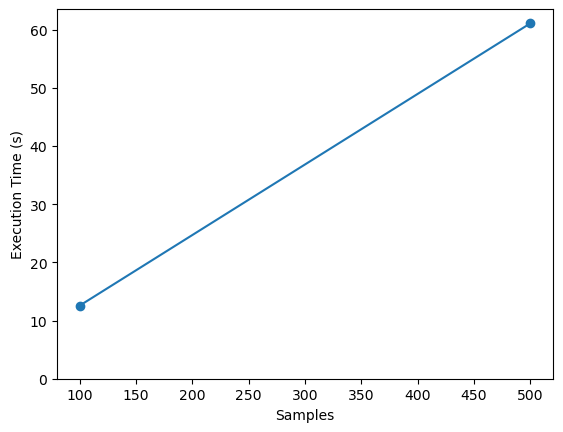

In [42]:
times = []
samples = []
for i in range(1, 102, 20):
    timer = pd.Timestamp("now")
    a = nearest_neighbor(ds, coords.sample(i)[["latitude", "longitude"]])
    times.append(time_since(timer))
    samples.append(i)
plt.plot(samples, times, marker="o")
plt.ylabel("Execution Time (s)")
plt.xlabel("Samples")
plt.ylim(ymin=0)

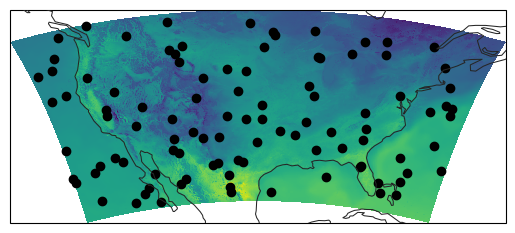

In [3]:
ax = EasyMap().ax

a = nearest_neighbor(ds, coords.sample(100)[["latitude", "longitude"]])

ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m)
ax.scatter(a.longitude, a.latitude, color="k")

# Benchmark

A simple benchmark suggests this is about the same runtime as my current `nearest_points` accessor


In [26]:
benchmark_points = coords.sample(100)[["latitude", "longitude"]]

In [27]:
%%time
a = nearest_neighbor(ds, benchmark_points)

CPU times: user 5.81 s, sys: 290 ms, total: 6.1 s
Wall time: 6.13 s


In [28]:
%%time
ds.herbie.nearest_points(benchmark_points)

/home/blaylock/GITHUB/Herbie/herbie/accessors.py:260: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.parse_cf()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:264: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.assign_y_x()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:264: UserWarning: More than one time coordinate present for variable  "d2m".
  ds = ds.metpy.assign_y_x()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:264: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.assign_y_x()


CPU times: user 6.68 s, sys: 109 ms, total: 6.79 s
Wall time: 6.79 s


<xarray.Dataset>
Dimensions:              (point: 100)
Coordinates:
    time                 datetime64[ns] 2024-03-16
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (point) float64 30.28 40.06 33.14 ... 50.32 38.85 28.8
    longitude            (point) float64 246.9 230.8 253.8 ... 245.0 262.9 290.2
    valid_time           datetime64[ns] 2024-03-16
    metpy_crs            object Projection: lambert_conformal_conic
    y                    (point) float64 -7.893e+05 6.327e+05 ... -6.753e+05
    x                    (point) float64 -1.504e+06 -2.644e+06 ... 2.693e+06
  * point                (point) int64 478932 1331278 617684 ... 975969 548693
    point_latitude       (point) float64 30.28 40.06 33.14 ... 50.32 38.85 28.8
    point_longitude      (point) float64 246.9 230.8 253.8 ... 245.0 262.9 290.2
Data variables:
    t2m                  (point) float32 290.9 284.3 286.7 ... 274.4 288.0 295.0
    d2m                  (point) float32 282.6 282.7 271.3 ... 272.3 274.9 289.6
    gribfile_projection  (point) object None None None None ... None None None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240316/subset_44ef89f...
    searchString:            (?:TMP|DPT):2 m

# Sandbox

In [43]:
# Get vector of grid coordinates and indices
coords = ds[["latitude", "longitude"]].to_dataframe().reset_index()

# Sample points
coords.sample(i)[["latitude", "longitude"]]

In [ ]:
# Query points to find nearest neighbor
# TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
dist, ind = tree.query(points, k=k)


In [ ]:

# Get indices of those points
points = coords.loc[ind[:, 0]]

# Extract data from dataset
# TODO: Loop over neighbor number k

# TODO: Is there a better way? Maybe I don't want to return a Dataset, but a DataFrame
# There doesn't seem to be a way to get just the points like this
# ds = ds.sel(x=xs, y=ys, method='nearest')
# because it gives a 2D array, and not a point-by-point index.
# Instead, I have too loop the ds.sel method
timer = pd.Timestamp("now")
new_ds = xr.concat(
    [ds.sel(x=row.x, y=row.y) for idx, row in points.iterrows()],
    dim="point",
)
if verbose:
    print(f"Xarray concat: {time_since(timer)}")
